Discussion

1) the motivation behind the presented solutions



2) how you represent and preprocess the data

Task 1
Stop words: Here, the stop_words parameter is set to 'english' to remove common English words that are not typically useful for classification. 
Strip_accents: is set to 'ascii' to remove accents from characters in the text, which can be important for maintaining consistency across different languages or text sources.

Performed quite similar, didn't do anything using the two above, but might add them just to be safe.

Task 2

3) your idea and solution implementation for each of the two tasks listed above.

Task 1
- Not doing anything performed the worst
- 

Task 2
- 

4) the evaluation procedure (e.g., cross-validation or training/validation split)

Preprocessing: piping to avoid information leakage between training and validation sets
- countvectorisation()
- over/under sampling minority/majority

GridsearchCV: Searches Gridspace and does CV for each combination of hyperparameters and preprocessing parameters
- Using prior probabilities or not
- Laplace smoothing alpha value (to limit naives bayes equation denom/numer to drive to 0 for certain predictions when we get 0 instances of a word appearing given the class label)

5) the training/validation results. 



In [41]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [31]:
k_folds = 10
rs = 991

In [63]:
yelp_df = pd.read_csv('../data/input/train.csv')

X = yelp_df["review"]
y = yelp_df["category"]

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

Implement Naive Bayes using Unpreprocessed Data

In [64]:
params = {
    'clf__alpha': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
    'clf__fit_prior': [True, False]
}

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents = "ascii")),
    ('clf', MultinomialNB())
])

grid_search = GridSearchCV(pipeline, params, cv=k_folds, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

# See how well our model performs on test
best_estimator = grid_search.best_estimator_
test_prediction = best_estimator.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
mean_accuracy = test_accuracy.mean()
percent_std_dev = std_dev / mean_accuracy * 100

print('Average accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'clf__alpha': 0.5, 'clf__fit_prior': False}
Average accuracy: 87.6761  %
Standard deviation: 1.7434  %


Let's evaluate how balanced our class labels are...

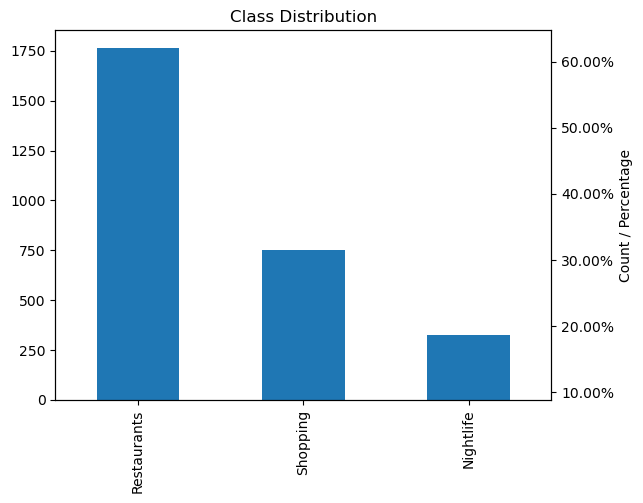

In [55]:
class_counts = y.value_counts()
# calculate the percentage of each class
class_percentages = (class_counts / class_counts.sum()) * 100

# create a bar plot of the categorical class distribution with percentages
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax)
ax2 = ax.twinx()
class_percentages.plot(kind='line', color='red', ax=ax2, linestyle="None",marker='None')
ax2.yaxis.set_major_formatter('{x:.2f}%')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count / Percentage')
plt.show()

"Restaurants" appears to be the majority class label, taking up to 62% of the class, followed by "Shopping" at 26% then "Nightlife" at 11%. This is not ideal when model building as we will see inherent bias towards classifiying a venue as a "Restaurant" compared to "Shopping" or "Nightlife". This is because the prior probabilities of restaruant P(yres) will be higher than that of P(ynight) and P(yshop) purely due to class label distribution. I solve this by performing oversampling of our minority class labels.

Implement Naive Bayes with Balanced Class Labels

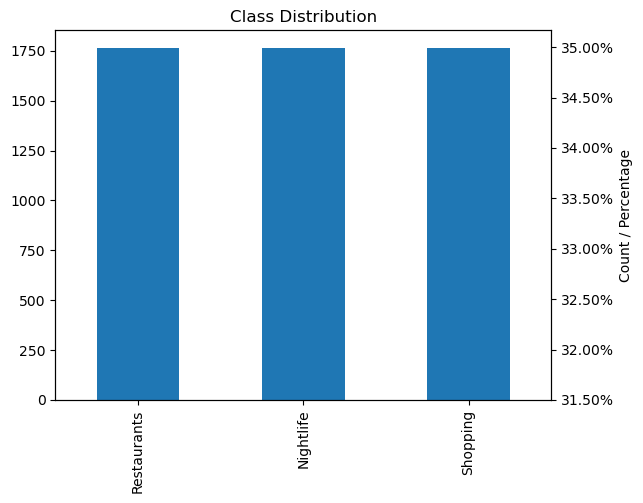

In [35]:
# count the frequency of each class label and desired class label size
class_counts = yelp_df['category'].value_counts()
desired_class_size = class_counts.max()

# oversample the minority classes to reach the desired class size
ros = RandomOverSampler(sampling_strategy='all', random_state=rs)
X_resampled, y_resampled = ros.fit_resample(yelp_df[['review']], yelp_df['category'])

class_counts = y_resampled.value_counts()
# calculate the percentage of each class
class_percentages = (class_counts / class_counts.sum()) * 100

# create a bar plot of the categorical class distribution with percentages
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax)
ax2 = ax.twinx()
class_percentages.plot(kind='line', color='red', ax=ax2, linestyle="None",marker='None')
ax2.yaxis.set_major_formatter('{x:.2f}%')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count / Percentage')
plt.show()

Class labels appear much more balanced. We carry on with modelling.

In [37]:
# create a bag of words representation of the review text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_resampled['review'])
y = y_resampled

# train the Naive Bayes model with 10-fold cross-validation
clf = MultinomialNB(fit_prior = True)
scores = cross_val_score(clf, X, y, cv=10)

# calculate the average accuracy and standard deviation of the model
print('Average accuracy:', round(scores.mean() * 100, 4), " %")
print('Standard deviation:', round(scores.std() * 100, 4), " %")

Average accuracy: 93.2394  %
Standard deviation: 0.8354  %


Significant improvement in accuracy and standard deviation. Let's try other preprocessing techniques

Issues we can encouter with text data...

ADD Laplace Smoothing